# Automatisiert Messen mit Python und dem IVI (VISA)-Standard
Version 11.12.2019, S. Mack
## Einleitung
In der Automatisierung ist öft nötig, ein Messgerät mit einem Computer zu verbinden. Dabei soll der Computer erstens das Messgerät konfigurieren, also aus der Ferne „bedienen“ können. Zweitens soll das Messgerät dem Computer die Messdaten oder andere Zustandsdaten wie z.B. den aktuellen Messbereich senden. Das Messgerät kann hierbei beispielsweise ein Digitalmultimeter, ein Funktionsgenerator oder ein Oszilloskop sein.  
  
Oft befinden sich an einer Automatisierungseinrichtung, beispielsweise eine Endprüfanlage, viele verschiedene Messgeräte, die von ein und dem selben Computer bedient werden müssen. Hat nun jedes dieser Messgeräte eine andere Schnittstelle und kommuniziert über andere Protokolle, so wird ein solches Messsystem nicht mehr handhabbar. Manchmal gibt es für das eine Gerät Programmierschnittstellen (APIs) nur für C und für das andere Gerät nur für Java, was einen gemeinsamen Einsatz beider Geräte unmöglich macht. Oder für ein und das selbe Gerät gibt es für die gewählte Programmiersprache zwar das Kommunikationsprotokoll jedoch keine API für die Schnittstelle als fertige Bibliothek.  
Dieses Dilemma hat man schon 1962 erkannt, als der RS-232-Standard für die Gerätekommunikation eingeführt wurde, welcher erstaunlicherweise bis heute überlebt hat.  
  
Mitte der 1990er Jahre wurde der **VISA-Standard (Virtual Instrument Software Achitecture) eingeführt, der es erlaubt, Messgeräte unabhängig von deren Schnittstellen zu konfigurieren, programmieren und zu warten**. VISA kann für die Schnittstellen GPIB, VXI, PXI, Serial, Ethernet, und USB verwendet werden. VISA besteht aus einer API-Spezifikation für C, Visual Basic und G (LabVIEW). Unter Windows wird meistens als Standard-API die Laufzeitbibliothek `visa32.dll` bzw. `visa64.dll` verwendet (ist auch bei pyVISA der Fall).  

Zusätzlich zu den Schnittstellen hat man mit dem **SCPI-Standard (Standard Command for Programmable Instruments) die Protokolle, also die Messbefehle für unterschiedliche Messgeräte standardisiert. Er definiert Syntax, Befehlsstruktur und das Datenformat der Messbefehle**, die der PC an das Messgerät sendet. Die Messbefehle werden als ASCII-Zeichen übertragen.  
SCPI definiert folgende acht verschiedene Geräteklassen: "Chassis Dynamometers, Digital Meters, Digitizers, Emissions Benches, Emission Test Cell, Power Supplies, RF & Microwave Sources, Signal Switchers". Oszilloskope fallen unter die Geräteklasse „Digitizers".  
  
Inzwischen sind **VISA und SCPI im IVI-Standard (Interchangeable Virtual Instrument) vereint** worden:  
Schlussendlich **beinhaltet IVI somit einen Satz von Standardmessbefehlen für das Messgerät und eine API für unterschiedliche Schnittstellen**.  
Schließt man ein Oszilloskop via USB an einen PC an, dann wird ähnlich wie bei einer Coputertastatur ein generischer IVI-Treiber geladen. Im Windows-Gerätemanager erscheint dann ein „USB Test and Measurement Device (IVI)“, Gerätetyp: „USB Test and Measurement Devices“. Hersteller: „IVI Foundation, Inc.“. Ein gerätespezifischer Treiber für das spezielle Oszilloskop wird also nicht benötigt.  
Möchte man von diesem Oszilloskop nun Hersteller, Modell, Seriennummer und Firmwarestand wissen, so muss der ensprechende SCPI-Befehl `*IDN?` als ASCII-Zeichen über die USB-Schnittstelle an das Oszilloskop gesendet werden.  
SCPI beinhaltet eine Vielzahl standardisierter Messbefehle (z.B. `MEAS:FREQ?` für die Anforderung der gemessenen Frequenz). SCPI-Befehle sind baumartig aufgebaut: In diesem Beispiel ist ` MEAS` der Root-Befehl und `FREQ` ist ein Parameter. Es reicht, bei den Messbefehlen immer nur den großgeschriebenen Teil zu senden, also `MEAS:FREQ?` statt ausgeschrieben `MEASure:FREQuency?`.  
Leider implementieren nicht alle Messgerätehersteller diese Befehle in gleichem Umfang oder gleichem Wortlaut. Daher muss man **vorher immer im Programmierhandbuch des Messgeräts den tatsächlichen Befehl nachschlagen**.  
Soll das Messgerät nach dem Befehl Daten zurückliefern, dann wird der Befehl mit einem Fragezeichen `?` abgeschlossen. Ein Konfigurationsbefehl benötigt kein Fragezeichen.  
  
Python kann grundsätzlich C-Laufzeitbibliotheken - also auch die oben erwähnte VISA Dlls verwenden. Darüber hinaus gibt es unter Python die Bibliothek `pyVISA`, um in einfacher Weise auf diese DLLs zuzugreifen. In den nachfolgenden Beispielen werden diese beiden Softwarekomponenten verwendet, um via USB ein Oszilloskop zu konfigurieren, Messungen zu intialisieren und die Messdaten auszulesen.  
Darüberhinaus wird der gemessene Spannungsverlauf mit den Python-Bibliotheken `Numpy` und `Matplotllib` grafisch visualisiert.

## Verwendung von Python für die Messtechnik
Grundsätzlich gibt es verschiedene Möglichkeiten, über Python mit einem Messgerät zu kommunizieren: 
* Man kann im Kommandofenster mit dem Pythoninterpreter interaktiv arbeiten bzw. eine Skriptdatei als Ganzes darin ausführen lassen.
* Wesentlich bequemer ist eine Python-IDE wie z.B. "Spyder", die einen Editor enthält, in dem das Skript mit Codervervollständigung usw. erstellt wird. Ähnlich wie die MATLAB-IDE enthält Spyder auch einen Variable-Explorer und andere nützliche Features für das Debuggen. Zusätzlich gibt es in Spyder auch eine IPython-Konsole, mit der interaktiv Codeschnipsel aus dem Editor im Python-Interpreter getestet werden können. Diese Vorgehensweise wird im Praktikum Messtechnik verfolgt.
* Der hier in diesem Jupyter Notebook verwendete Python-Interpreter basiert ebenfalls auf IPython. Hier liegt aber der Schwerpunkt auf der Dokumentation des Quelltextes und nicht auf dessen Ausführung. Wenn Sie dieses Jupyter Notebook durcharbeiten, dann werden Sie vermutlich nicht ein Oszilloskop am PC angeschlossen haben, um mit Codesequenzen zu spielen. Daher reicht es, wenn Sie dieses Notebook über einen Viewer durcharbeiten.

Später im Praktikum erstellen Sie unter der IDE Spyder die Messsoftware im Editor und können die einzelnen Befehlszeilen getrennt in der IPython Konsole testen (dafür die Befehlszeile im Editor markieren, rechte Maustaste > "Run Cell").  
**Die nachfolgenden Codebeispiele setzen Grundkenntnisse in Python sowie in den beiden Bibliotheken Numpy und Matplotlib voraus. Bitte arbeiten Sie vorher das Grundlagenkapitel des Jupyter Notebooks für die Bildverarbeitung durch.**

## Beispiel Python Code für Oszilloskop Rigol DS1054Z
Nachfolgend ist beispielhaft für ein Rigol DS1054Z gezeigt, wie nach IVI-Geräten gesucht wird, die Kommunikation mit einem gefundenen Gerät aufgebaut wird, dieses Gerät konfiguriert wird und wie die Messdaten ausgelesen werden.  
Die hierfür verwendeten Befehle sind leider nur teils "echte" SCPI-Befehle. Sie werden im Praktikum ein anderes Oszilloskop verwenden, das für einige Funktionen teils andere Befehle verwendet.  
Die korrekten Befehle finden Sie im Programmierhandbuch des jeweiligen Oszilloskops.

### Import der nötigen Pythonbibliotheken
Für die Kommunikation mit dem Oszilloskop werden die Bibliothek `pyVISA`, für die spätere Datenauswertung und -visualisierung die Bibliotheken `Numpy` und `Matplotlib` importiert. Die Funktion `sleep()` aus der Bibliothek `time` wird für nur für Wartebefehle verwendet, da das Oszilloskop manchmal wie bei dem Befehl `:AUToset`eine gewisse Zeit benötigt, bis ein Befehl ausgeführt wurde.

In [1]:
import visa
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

### Suche nach IVI-Geräten und Verbindungsaufbau mit dem Oszilloskop
Wenn im Windows Gerätemanager das Oszilloskop als "USB Test and Measurement Device (IVI)" erscheint, wird es durch folgende Befehle ausfindig gemacht und identifiziert:

In [2]:
rm=visa.ResourceManager()
inst_found=rm.list_resources() # IVI Geräte finden, Identifikationdaten in Liste abspeichern
print(inst_found)

('USB0::0x1AB1::0x04CE::DS1ZA181004388::INSTR', 'ASRL10::INSTR')


Das erste Element (Index Null) der Liste `inst_found` enthält (hier in dieser speziellen Konfiguration!) das via USB angeschlossene Oszilloskop. Anschließend wird eine Verbindung aufgebaut. Damit erhält man das Objekt `inst` über dessen Methoden und Attribute auf das Messgerät zugegriffen wird.  
Wenn Sie in der Spyder IPython-Konsole nun `inst. + <TAB>` eingeben, erscheint eine Auswahl an Methoden und Attribute für diese Klasse.

In [3]:
inst=rm.open_resource(inst_found[0])

### Konfigurieren des Oszilloskops
Mit dem folgenden Befehlen wird das Oszilloskop konfiguriert und Einstellungswerte werden abgefragt. Siehe Kommentare hinter den jeweiligen Befehlen. Für Befehle mit Rückgabewert - zu erkennen am abschließenden Fragezeichen im Befehlsstring - wird `query()` verwendet, für reine Schreibbefehle `write()`.

In [4]:
inst.query('*IDN?') # Hersteller, Gerätetyp, Seriennummer und Firmwarestand abfragen

'RIGOL TECHNOLOGIES,DS1054Z,DS1ZA181004388,00.04.03.SP2\n'

In [5]:
inst.write('*CLS') # Befehls- und Fehlerspeicher löschen
inst.write(':AUT') # Autoset durchführen
sleep(5) # 5 Sekunden warten, nötig da sonst Programmabsturz, falls Oszi noch nicht fertig bei nächstem Befehl

In [6]:
inst.query(':WAV:SOUR?') # Aktiver Kanal abfragen

'CHAN1\n'

In [7]:
inst.query(':CHAN1:COUP?') # Kopplungsarte des Oszilloskopeingangs

'DC\n'

## Messwerte und gesampelten Spannungsverlauf auslesen
Am Oszilloskop ist am Kanal 1 ein Tastkopf angeschlossen, der vom Rechteckgenerator für die Tastkopfkalibrierung des Oszilloskops ein Signal erhält.  
Als Beispiel wird nachfolgend eine Frequenzmessung ausgeführt.

In [8]:
inst.query('MEAS:FREQ? CHAN1')

'9.999999e+02\n'

Im nächsten Codebeispiel wird zuerst das Oszilloskop so konfiguriert, dass es später für den gesampelten Spannungsverlauf als ASCII-String ausgibt. Anschließend werden diese Messdaten vom Oszilloskop angegefordert und in eine Stringvariable kopiert.  
In diesem String sind die einzelnen Spannungswerte mit Kommata getrennt. Die ersten 30 Zeichen des Srtrings mit den Messwerten werden testweise ausgegeben.

In [9]:
inst.write(':WAV:FORM ASC') # Messkurvenausgabe als ASCII-Werte anfordern
values_raw = inst.query(':WAV:DATA?') # Messkurve als einen durchgehenden String ausgeben
print(values_raw[:50]) # Erste 50 Zeichen testweise ausgeben

#90000156631.999961e-02,3.999961e-02,1.999961e-02,


Die ersten 11 Zeichen des Messwertestrings sind offensichtlich keine Spannungsmesswerte und werden daher ignoriert. Über die Stringfunktion `.split()` wird aus dem langen String ab dem 12. Zeichen eine Liste mit Strings erzeugt mit je einem Spannungswert pro Element.

In [10]:
values_string_sep = values_raw[11:].split(',') # Lise mit Strings für jeden Messpunkt ab Zeichen 12

Um im folgenden Kapitel diese Messwerte grafisch darstellen zu können, müssen diese zuerst in eine Liste mit Floats umgewandelt werden.  
Außerdem muss noch das Samplingintervall (Zeit zwischen den einzelnen Messwerten) vom Oszillokop ausgelesen werden, um später die x-Achse skalieren zu können.

In [11]:
values_float = [] # Umwandlung Stringliste in Floatliste
for item in values_string_sep:
    values_float.append(float(item))
delta_t = inst.query(':WAV:XINC?')[:-1] # Samplingintervall ausgeben
print(delta_t)

2.000000e-06


## Darstellung der gesampelten Spannungsverlaufs in einem Plot
Zuerst wird die Liste mit den Spannungsmesswerten in ein Numpy-Array umgewandelt. 
Neu in diesem Codebeispiel ist die anschließende Numpy-Funktion `arange()`, die das Array für die Samplingzeiten der Messpunkte berechnet, welches später im Plot als Array für die x-Werte dient.  
Anschließend werden mit dem Modul `pyplot` von Matplotlib die Messwerte grafisch ausgeben.

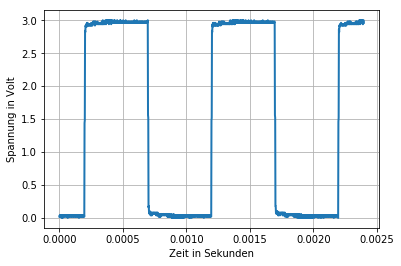

In [12]:
y_val = np.array(values_float)
dt=float(delta_t)
x_val = np.arange(0.0, len(values_float)*dt, dt) # x-Werte berechnen

plt.plot(x_val,y_val,linewidth=2)
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Spannung in Volt')
plt.grid(True)

In [13]:
inst.close # Beenden der Kommunikation mit dem Oszilloskop

<bound method Resource.close of <'USBInstrument'('USB0::0x1AB1::0x04CE::DS1ZA181004388::INSTR')>>